<a href="https://colab.research.google.com/github/greymouse1/statistics/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Statistics final project

In [32]:
import pandas
from scipy import stats
import numpy
import itertools
from tabulate import tabulate
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

# Imported functions

In [2]:
# Functions in this block are provided by the course lecturers
# Some of the code in other cells was also take from the course
# Python examples. Courtesy of the course lecturers.

def get_confidence_interval(data, confidence=0.95):
    """ Determines the confidence interval for a given set of data,
        assuming the population standard deviation is not known.

    Args:  # 'arguments', or inputs to the function
        data (single-column or list): The data
        confidence (float): The confidence level on which to produce the interval.

    Returns:
        c_interval (tuple): The confidence interval on the given data (lower, upper).
    """

    n = len(data)  # determines the sample size
    m = numpy.mean(data)  # obtains mean of the sample

    se = stats.sem(data)  # obtains standard error of the sample

    c_interval = stats.t.interval(confidence, n-1, m, se)  # determines the confidence interval
    return c_interval  # which is of the form (lower bound, upper bound)

def t_test(data_group1, data_group2, confidence=0.95):
    alpha = 1-confidence

    if stats.levene(data_group1, data_group2)[1]>alpha:
        equal_variance = True
    else:
        equal_variance = False

    t, p = stats.ttest_ind(data_group1, data_group2, equal_var = equal_variance)

    reject_H0 = "True"
    if p > alpha:
        reject_H0 = "False"

    return({'t': t, "p": p, "Reject H0": reject_H0})

def ANOVA(dataset,independent,dependent,confidence = 0.95):
    """ Calculates the ANOVA for a given dataset and prints an ANOVA table
        and results of post hoc test if test was performed.

    Args:  # 'arguments', or inputs to the function
        dataset (pandas.DataFrame): The data
        independent (string): The name of the independent column.
        dependent (string): The name of the dependent column.
        confidence (float): The desired confidence level for the ANOVA.

    Returns:
        None.
    """
    groups = pandas.unique(dataset[independent])
    k = len(groups)  # number of groups
    n = len(dataset[dependent])  # number of dependent data points

    # here we calculate the three degrees of freedom used in the ANOVA
    DFbetween = k - 1
    DFwithin = n - k
    DFtotal = n - 1

    # we use textbook notation:
    # x_dd = sum over i and j x_ij
    # x_id = sum over j x_ij
    # x_dj = sum over i x_ij
    # where i is the independent variable and j is the dependent variable

    x_dd = sum(dataset[dependent])
    CF = (x_dd**2)/n

    SStotal = sum(x_ij**2 for x_ij in dataset[dependent]) - CF

    SSbetween = 0
    for i in groups:
        group_data = dataset.loc[dataset[independent]==i]
        n_i = len(group_data[dependent])
        x_id = sum(group_data[dependent])
        SSbetween += (x_id**2)/n_i

    SSbetween = SSbetween - CF  # so^2 - s^2

    SSwithin = SStotal - SSbetween

    MSbetween = SSbetween/DFbetween
    MSwithin = SSwithin/DFwithin

    F = MSbetween/MSwithin
    p = stats.f.sf(F, DFbetween, DFwithin)

    print(tabulate([['Between', DFbetween, SSbetween, MSbetween, F],
                    ['Within', DFwithin, SSwithin, MSwithin, ' '],
                    ['Total', DFtotal, SStotal, ' ', ' ']],
    headers=['Variation due to', 'DoF','Sum of squares','mean squares','F ratio']))
    print('Significance (p value): '+str(p))
    print('\n')
    alpha = 1-confidence
    if p < alpha:
        print("Reject null-hypothesis: There are statistical differences present.")
        print(pairwise_tukeyhsd(dataset[dependent], dataset[independent], alpha=alpha))
    else:
        print("Fail to reject the null-hypothesis: There are no statistical differences present at this level of significance.")

# First question

In [3]:
# First step is to load the csv file

# URL for csv
data_url = "https://raw.githubusercontent.com/greymouse1/statistics/refs/heads/main/PRO1_dataset.csv"

# Loaded file into data frame
df = pandas.read_csv(data_url)

# Calculate year mean in new column
df["year_mean"] = df.iloc[:,1:].mean(axis=1)

# Since we need decades I will remove years from 1756-1759 (inclusive)
# and year 2020. Decades will start at year ending with 0 and stop at
# year ending with 9. Otherwise I can't avoid having one uncomplete decade
# so this is for the sake of simplicity
df.drop(df.index[0:4], inplace=True)
df.drop(df[df["year"]==2020].index, inplace=True)

# Reset the index
df = df.reset_index(drop=True)

# Create column for decade
# This will be first year of the decade but will include
# the data for that year and all subsequent 9 years
# For example, decade 1760 is decade with data for interval 1760-1769 (inc)
df["decade"] = (df["year"]//10) * 10

# Group values into new dataframe by year
df_decade = df.groupby("decade").agg({"year_mean": "mean"}).reset_index()

# Rename column name for decade means
df_decade.rename(columns={"year_mean":"decade_mean"}, inplace=True)

In [ ]:
# As a general assumption, we assume all years should have same means
# Then we can look at all decades as one dataset or all years as one dataset

# First let's use the index plot
# Indices will be each decade

fig = pyplot.Figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

df_decade.reset_index().plot(x='index', y="decade_mean", kind='scatter', ax=ax1)
df.reset_index().plot(x='index', y="year_mean", kind='scatter', ax=ax2)

ax1.set(
        xlabel='Index (decades)',
        ylabel='$x$'
    )
ax2.set(
        xlabel='Index (years)',
        ylabel='$x$'
    )
fig

# There seem to be some outliers in the top right corner for the last two decades

In [ ]:
# Let's see how histograms look like
fig = pyplot.Figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

df["year_mean"].plot(kind="hist", bins=10, alpha = 0.7, ax=ax1)
df_decade["decade_mean"].plot(kind="hist", bins=5, alpha = 0.7, ax=ax2)

ax1.set(
        xlabel='$x$',
        ylabel='Frequency'
    )
ax2.set(
        xlabel='$x$',
        ylabel='Frequency'
    )
fig

# When looking at years, it may be that the data is normally distributed while for the decades we ahave only 26
# data points and creating histogram will be inconclusive based on the number of bins we decide to choose

In [ ]:
fig = pyplot.Figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

df.boxplot(column="year_mean", ax=ax1)
df_decade.boxplot(column="decade_mean", ax=ax2)

ax1.set(
        xlabel='Sample',
        ylabel='$x$'
    )

ax2.set(
        xlabel='Sample',
        ylabel='$x$'
    )
fig

# He we compare box plot for all years and for all decades
# There seem to be some decades which stand out of the mean for all the decades

In [ ]:
# To check for years which could stand out for each individual decade, there has to be a box plot for
# each of the decades
# Create a figure with a specified size
fig, ax = pyplot.subplots(figsize=(12, 6))  # Use the appropriate size here

# Plot the boxplot for temperatures by decade
df.boxplot(column='year_mean', by='decade', patch_artist=True, ax=ax)

# Adding labels and title
ax.set_title('Yearly Temperature Distribution by Decade')
pyplot.suptitle('')  # Remove the default title generated by `boxplot()`
ax.set_xlabel('Decade')
ax.set_ylabel('Temperature')

# Show the plot
pyplot.show()

fig.savefig('temperature_distribution.png')



# Second question


In [ ]:
# Data now has to be grouped by century
# For this I use original dataset
df["century"] = (df["year"]//100) + 1

# Separate by century
df_19th = df[df["century"] == 19]["year_mean"].reset_index(drop=True)
df_20th = df[df["century"] == 20]["year_mean"].reset_index(drop=True)

# Group values into new dataframe by century
df_century = pandas.concat({"19th": df_19th, "20th": df_20th}, axis=1)

# Create a figure with a specified size
specific_centuries = [19, 20]
filtered_df = df[df["century"].isin(specific_centuries)]
fig, ax = pyplot.subplots(figsize=(6, 3))  # Use the appropriate size here

# Plot the boxplot for temperatures by decade
filtered_df.boxplot(column='year_mean', by='century', patch_artist=True, ax=ax)

# Adding labels and title
ax.set_title('Yearly Temperature Distribution by century')
pyplot.suptitle('')  # Remove the default title generated by `boxplot()`
ax.set_xlabel('Century')
ax.set_ylabel('Temperature')

# Show the plot
pyplot.show()
fig.savefig('temperature_distribution_centuries.png')

In [ ]:
# Get group statistics
print(df_century.describe())

In [ ]:
# Check the confidence intervals
print("Century 19", get_confidence_interval(df_century["19th"], confidence=0.95))
print("Century 20:", get_confidence_interval(df_century["20th"], confidence=0.95))

In [ ]:
# t-test
t_test(df_century["19th"], df_century["20th"], confidence=0.95)

# Third question

In [ ]:
# Create new df for the last five centuries

decade1970 = df[df["decade"] == 1970]["year_mean"].reset_index(drop=True)
decade1980 = df[df["decade"] == 1980]["year_mean"].reset_index(drop=True)
decade1990 = df[df["decade"] == 1990]["year_mean"].reset_index(drop=True)
decade2000 = df[df["decade"] == 2000]["year_mean"].reset_index(drop=True)
decade2010 = df[df["decade"] == 2010]["year_mean"].reset_index(drop=True)
df_five_decades = pandas.concat({"1970": decade1970, "1980": decade1980, "1990": decade1990, "2000": decade2000, "2010": decade2010}, axis=1)

# Shapiro-Wilk test
for decade in df_five_decades.columns:
    print(f"Results of the Shapiro-Wilk for decade {decade}:", stats.shapiro(df_five_decades[decade]))

In [ ]:
fig = pyplot.Figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

df_five_decades.reset_index().plot(x='index', y="2010", kind='scatter', ax=ax1)


ax1.set(
        xlabel='Index (decades)',
        ylabel='$x$'
    )
fig
fig.savefig('five_decades.png')

In [ ]:
# Leven test
for decade1, decade2 in itertools.combinations(df_five_decades.columns,2):
    print(decade1, decade2, stats.levene(df_five_decades[decade1], df_five_decades[decade2]))

In [ ]:
# Welch ANOVA for unequal variances
f_stat, p_value = stats.f_oneway(
    df_five_decades['1970'],
    df_five_decades['1980'],
    df_five_decades['1990'],
    df_five_decades['2000'],
    df_five_decades['2010']
)
print(f"F-statistic: {f_stat}")
print(f"p-value: {p_value}")

In [ ]:
# Posthoc
df_long = df_five_decades.melt(var_name='decade', value_name='temperature')

df_long.head()

!pip install pingouin
import pingouin as pg

# Perform the Games-Howell post-hoc test
posthoc = pg.pairwise_gameshowell(dv='temperature', between='decade', data=df_long)

# Display the results
print(posthoc)

# Fourth question

In [31]:
# Data has to be remodelled so it has summer and winter means
# For this I use starting raw data
# Loaded file into data frame
df_summer_winter = pandas.read_csv(data_url)

# Create an empty DataFrame to store the results
summary_df = pandas.DataFrame(columns=["year", "mean_summer", "mean_winter"])

# Loop through each unique year
for selected_year in df_summer_winter["year"].unique():
    # Select the row for the specific year
    selected_row = df_summer_winter[df_summer_winter["year"] == selected_year]

    # Calculate the average for the winter months
    # December of the current year and January, February of the next year
    if selected_year + 1 in df_summer_winter["year"].values:
        # Calculate the average for the summer months (June, July, August)
        summer_avg = selected_row[["jun", "jul", "aug"]].mean(axis=1).values[0]

        next_year_row = df_summer_winter[df_summer_winter["year"] == selected_year + 1]
        winter_avg = (selected_row["dec"].values[0] + next_year_row["jan"].values[0] + next_year_row["feb"].values[0]) / 3

    else:
        break  # Handle case if no next year (e.g., for the last year in dataset)

    # Append the results to the summary DataFrame
    summary_df = pandas.concat([summary_df, pandas.DataFrame({
    "year": [selected_year],
    "mean_summer": [summer_avg],
    "mean_winter": [winter_avg]
    })], ignore_index=True)




<ipython-input-31-1f0167c531e4>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pandas.concat([summary_df, pandas.DataFrame({


[[1.48584129 0.14540353]
 [0.14540353 4.88554723]]


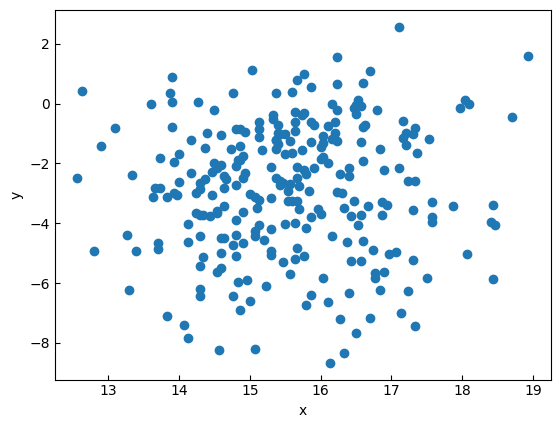

In [38]:
# Correlation

# Correlation coefficients
x = summary_df['mean_summer']
y = summary_df['mean_winter']
M = numpy.stack((x,y), axis=0)
print(numpy.cov(M))

# Plot temperatures
fig = pyplot.figure()
ax = fig.add_subplot()
ax.tick_params(axis='both', direction='in')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.scatter(x, y)
fig.savefig('correlation.png')

In [39]:
r, _ = stats.pearsonr(x, y)
print(f"Pearson correlation coefficient is {r}")

# Test normality with Shapiro-Wilk
print("x: ", stats.shapiro(x))
print("y: ", stats.shapiro(y))

Pearson correlation coefficient is 0.05396747834738869
x:  ShapiroResult(statistic=0.9948090799468385, pvalue=0.5114922621969263)
y:  ShapiroResult(statistic=0.9878118240890283, pvalue=0.024858338950417256)


y = -4.40434880260435 + 0.09785939427586907x


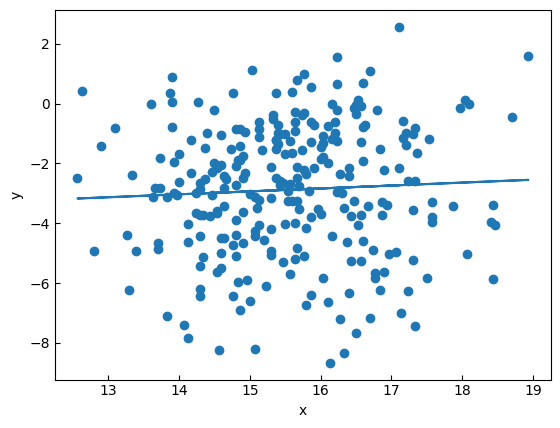

In [45]:
# Linear regression
regression = LinearRegression()
x = numpy.array(x)
x_reg = x.reshape(-1, 1)
y = numpy.array(y)
y_reg = y.reshape(-1,1)
regression.fit(x_reg, y_reg)
a = regression.intercept_[0]
b = regression.coef_[0][0]
print(f"y = {a} + {b}x")

y_estimated = a + b*x_reg

fig = pyplot.figure()
ax = fig.add_subplot()
ax.tick_params(axis='both', direction='in')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.scatter(x_reg, y_reg)
ax.plot(x_reg, y_estimated)
fig.savefig('linear_regression.png')

In [42]:
# R square
r_squared = stats.pearsonr(x, y)[0]**2
print("Pearson r squared: ", r_squared)
r_squared = regression.score(x_reg, y_reg)
print("Sklearn r squared: ", r_squared)

Pearson r squared:  0.002912488719175867
Sklearn r squared:  0.00291248871917571


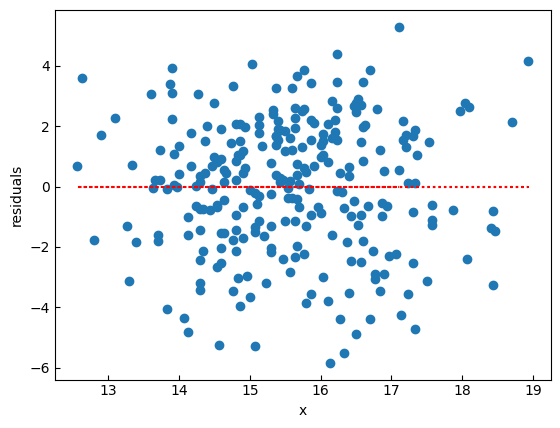

In [44]:
residuals =y_reg - y_estimated # calculate the residuals

fig = pyplot.figure() # generate and format our figure
ax = fig.add_subplot()
ax.tick_params(axis='both', direction='in')
ax.set_xlabel('x')
ax.set_ylabel('residuals')

ax.scatter(x_reg, residuals) # plot the residuals

xaxis = numpy.zeros_like(x_reg)  # make an array to plot the zero line
ax.plot(x_reg, xaxis, ls='dotted', c='red')  # plot the zero line with formatting